In [245]:
'''
Created on Jan 8, 2011

@author: Peter
'''
from numpy import *

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) - 1 #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

def standRegres(xArr,yArr):
    xMat = mat(xArr); yMat = mat(yArr).T
    xTx = xMat.T*xMat
    if linalg.det(xTx) == 0.0:
        print "This matrix is singular, cannot do inverse"
        return
    ws = xTx.I * (xMat.T*yMat)
    print xTx.I
    print xMat.T*yMat
    return ws

def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = mat(xArr); yMat = mat(yArr).T
    m = shape(xMat)[0]
    weights = mat(eye((m)))
    for j in range(m):                      #next 2 lines create weights matrix
        diffMat = testPoint - xMat[j,:]     #
        weights[j,j] = exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if linalg.det(xTx) == 0.0:
        print "This matrix is singular, cannot do inverse"
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws

def lwlrTest(testArr,xArr,yArr,k=1.0):  #loops over all the data points and applies lwlr to each one
    m = shape(testArr)[0]
    yHat = zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat

def lwlrTestPlot(xArr,yArr,k=1.0):  #same thing as lwlrTest except it sorts X first
    yHat = zeros(shape(yArr))       #easier for plotting
    xCopy = mat(xArr)
    xCopy.sort(0)
    for i in range(shape(xArr)[0]):
        yHat[i] = lwlr(xCopy[i],xArr,yArr,k)
    return yHat,xCopy

def rssError(yArr,yHatArr): #yArr and yHatArr both need to be arrays
    return ((yArr-yHatArr)**2).sum()

def ridgeRegres(xMat,yMat,lam=0.2):
    xTx = xMat.T*xMat
    denom = xTx + eye(shape(xMat)[1])*lam
    if linalg.det(denom) == 0.0:
        print "This matrix is singular, cannot do inverse"
        return
    ws = denom.I * (xMat.T*yMat)
    return ws
    
def ridgeTest(xArr,yArr):
    xMat = mat(xArr); yMat=mat(yArr).T
    yMean = mean(yMat,0)
    yMat = yMat - yMean     #to eliminate X0 take mean off of Y
    #regularize X's
    xMeans = mean(xMat,0)   #calc mean then subtract it off
    xVar = var(xMat,0)      #calc variance of Xi then divide by it
    xMat = (xMat - xMeans)/xVar
    numTestPts = 30
    wMat = zeros((numTestPts,shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat,yMat,exp(i-10))
        wMat[i,:]=ws.T
    return wMat

def regularize(xMat):#regularize by columns
    inMat = xMat.copy()
    inMeans = mean(inMat,0)   #calc mean then subtract it off
    inVar = var(inMat,0)      #calc variance of Xi then divide by it
    inMat = (inMat - inMeans)/inVar
    return inMat

def stageWise(xArr,yArr,eps=0.01,numIt=100):
    xMat = mat(xArr); yMat=mat(yArr).T
    yMean = mean(yMat,0)
    yMat = yMat - yMean     #can also regularize ys but will get smaller coef
    xMat = regularize(xMat)
    m,n=shape(xMat)
    returnMat = zeros((numIt,n)) #testing code remove
    ws = zeros((n,1)); wsTest = ws.copy(); wsMax = ws.copy()
    for i in range(numIt):#could change this to while loop
        #print ws.T
        lowestError = inf; 
        for j in range(n):
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat*wsTest
                rssE = rssError(yMat.A,yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i,:]=ws.T
    return returnMat

def scrapePage(inFile,outFile,yr,numPce,origPrc):
    from BeautifulSoup import BeautifulSoup
    fr = open(inFile); fw=open(outFile,'a') #a is append mode writing
    soup = BeautifulSoup(fr.read())
    i=1
    currentRow = soup.findAll('table', r="%d" % i)
    while(len(currentRow)!=0):
        currentRow = soup.findAll('table', r="%d" % i)
        title = currentRow[0].findAll('a')[1].text
        lwrTitle = title.lower()
        if (lwrTitle.find('new') > -1) or (lwrTitle.find('nisb') > -1):
            newFlag = 1.0
        else:
            newFlag = 0.0
        soldUnicde = currentRow[0].findAll('td')[3].findAll('span')
        if len(soldUnicde)==0:
            print "item #%d did not sell" % i
        else:
            soldPrice = currentRow[0].findAll('td')[4]
            priceStr = soldPrice.text
            priceStr = priceStr.replace('$','') #strips out $
            priceStr = priceStr.replace(',','') #strips out ,
            if len(soldPrice)>1:
                priceStr = priceStr.replace('Free shipping', '') #strips out Free Shipping
            print "%s\t%d\t%s" % (priceStr,newFlag,title)
            fw.write("%d\t%d\t%d\t%f\t%s\n" % (yr,numPce,newFlag,origPrc,priceStr))
        i += 1
        currentRow = soup.findAll('table', r="%d" % i)
    fw.close()
    
def setDataCollect():
    scrapePage('setHtml/lego8288.html','out.txt', 2006, 800, 49.99)
    scrapePage('setHtml/lego10030.html','out.txt', 2002, 3096, 269.99)
    scrapePage('setHtml/lego10179.html','out.txt', 2007, 5195, 499.99)
    scrapePage('setHtml/lego10181.html','out.txt', 2007, 3428, 199.99)
    scrapePage('setHtml/lego10189.html','out.txt', 2008, 5922, 299.99)
    scrapePage('setHtml/lego10196.html','out.txt', 2009, 3263, 249.99)
    
def crossValidation(xArr,yArr,numVal=10):
    m = len(yArr)                           
    indexList = range(m)
    errorMat = zeros((numVal,30))#create error mat 30columns numVal rows
    for i in range(numVal):
        trainX=[]; trainY=[]
        testX = []; testY = []
        random.shuffle(indexList)
        for j in range(m):#create training set based on first 90% of values in indexList
            if j < m*0.9: 
                trainX.append(xArr[indexList[j]])
                trainY.append(yArr[indexList[j]])
            else:
                testX.append(xArr[indexList[j]])
                testY.append(yArr[indexList[j]])
        wMat = ridgeTest(trainX,trainY)    #get 30 weight vectors from ridge
        for k in range(30):#loop over all of the ridge estimates
            matTestX = mat(testX); matTrainX=mat(trainX)
            meanTrain = mean(matTrainX,0)
            varTrain = var(matTrainX,0)
            matTestX = (matTestX-meanTrain)/varTrain #regularize test with training params
            yEst = matTestX * mat(wMat[k,:]).T + mean(trainY)#test ridge results and store
            errorMat[i,k]=rssError(yEst.T.A,array(testY))
            #print errorMat[i,k]
    meanErrors = mean(errorMat,0)#calc avg performance of the different ridge weight vectors
    minMean = float(min(meanErrors))
    bestWeights = wMat[nonzero(meanErrors==minMean)]
    #can unregularize to get model
    #when we regularized we wrote Xreg = (x-meanX)/var(x)
    #we can now write in terms of x not Xreg:  x*w/var(x) - meanX/var(x) +meanY
    xMat = mat(xArr); yMat=mat(yArr).T
    meanX = mean(xMat,0); varX = var(xMat,0)
    unReg = bestWeights/varX
    print "the best model from Ridge Regression is:\n",unReg
    print "with constant term: ",-1*sum(multiply(meanX,unReg)) + mean(yMat)


[[ 0.0189633  -0.02859463]
 [-0.02859463  0.05855728]]
[[ 767.1203    ]
 [ 403.55094194]]
This matrix is singular, cannot do inverse
This matrix is singular, cannot do inverse
This matrix is singular, cannot do inverse
This matrix is singular, cannot do inverse
This matrix is singular, cannot do inverse


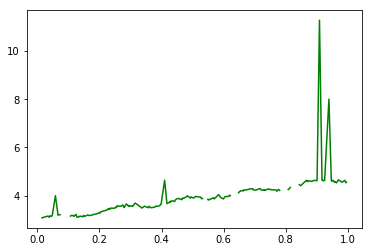

In [246]:
X, y = loadDataSet("ex0.txt")
ws = standRegres(X,y)
yHat,xCopy = lwlrTestPlot(X, y, 0.001)
#plt.scatter(X[:,1], y)
plt.plot(xCopy[:,1], yHat, c='g')
plt.show()

In [97]:
from numpy import * 
import matplotlib.pyplot as plt

def loadData(name):
    data = []
    y = []
    f = open(name)
    for x in f.readlines():
        x = x.strip().split('\t')
        data.append(map(float, x[:-1]))
        y.append(float(x[-1]))
    return array(data), array(y)

def lr(X, y):
    xTx = X.T.dot(X)
    if linalg.det(xTx) == 0.0:
        print "singular"
        return 
    w = linalg.inv(xTx).dot(X.T).dot(y)
    return w

def predict(X, y, w):
    y_bar = X.dot(w)
    return y_bar

def train_lr(): 
    X, y = loadData("ex0.txt")
    ws = lr(X, y)
    y_bar = predict(X, y, ws)
    index = X[:,1].argsort(0)
    plt.scatter(X[:,1], y)
    plt.plot(X[index,1], y_bar[index], c='g')
    plt.show()

def lwlr(X, y, k):
    W = eye(X.shape[0])
    y_bar = []
    for x in X:
        for i,xx in enumerate(X):
            W[i,i] = exp((x-xx).dot(x-xx) / (-2.0 * (k**2)))
        xTx = X.T.dot(W).dot(X)
        if linalg.det(xTx) == 0:
            print "sinbgular"
            y_bar.append(nan)
            continue
        w = linalg.inv(xTx).dot(X.T).dot(W).dot(y)
        y_bar.append(x.dot(w))
        W = eye(X.shape[0])
    return array(y_bar)
      
def train_lwlr(): 
    X, y = loadData("ex0.txt")
    y_bar = lwlr(X, y, 0.003)
    index = X[:,1].argsort(0)
    plt.scatter(X[:,1], y)
    plt.plot(X[index,1], y_bar[index], c='g')
    plt.show()

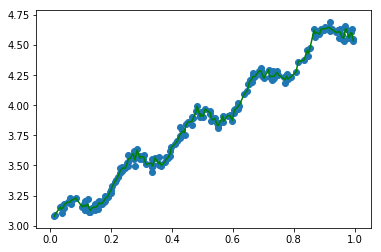

In [76]:
train_lwlr()

(200, 2)
(2,)


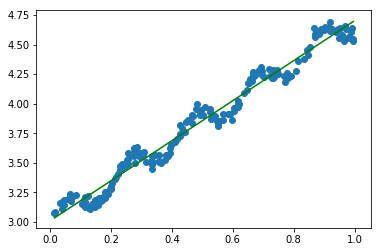

In [77]:
train_lr()

In [54]:
def rr(X, y, lam=0.2):
    xTx = X.T.dot(X)
    W = eye(X.shape[1]) * lam
    if linalg.det(xTx + W) == 0.0:
        print "singular"
        return 
    w = linalg.inv(xTx + W).dot(X.T.dot(y))
    return w

def train_rr():
    X, y = loadData("abalone.txt")
    X = X - mean(X, 0) / var(X, 0)
    y = y - mean(y, 0) / var(y, 0)
    w = rr(X, y)
    y_bar = predict(X, y, w)
    index = X[:,1].argsort(0)
    fig = plt.figure()
    ax = fig.add_subplot(2, 2, 1)
    ax.scatter(X[:,1], y)
    ax.plot(X[index,1], y_bar[index], c='g')
    WW = ones((30, X.shape[1]))
    for i in xrange(30):
        WW[i,:] = rr(X, y, exp(i - 10))
    ax = fig.add_subplot(2, 2, 2)
    ax.plot(WW)
    plt.show()

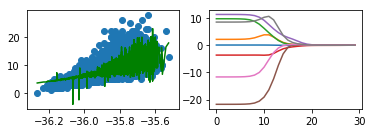

In [55]:
train_rr()

In [148]:
def fwr(X, y, eps=0.01, loops=1000):
    w = zeros(X.shape[1])
    wmax = w.copy()
    for k in xrange(loops):
        minErr = inf
        for j in xrange(len(w)):
            for ep in [-eps, eps]:
                w[j] += ep
                y_bar = X.dot(w)
                yErr = sum((y_bar-y)**2)
                if yErr < minErr:
                    minErr = yErr
                    wmax = w.copy()
                w[j] -= ep
        w = wmax.copy()
        print "{}".format(k), w
    return wmax

def train_fwr():
    X, y = loadData("abalone.txt")
    X = regularize(X) 
    y = y - mean(y, 0)
    w = fwr(X, y)
    y_bar = predict(X, y, w)
    index = X[:,1].argsort(0)
    fig = plt.figure()
    ax = fig.add_subplot(2, 2, 1)
    ax.scatter(X[:,1], y)
    ax.plot(X[index,1], y_bar[index], c='g')
    WW = ones((30, X.shape[1]))
    for i in xrange(30):
        WW[i,:] = rr(X, y, exp(i - 10))
    ax = fig.add_subplot(2, 2, 2)
    ax.plot(WW)
    plt.show()     

0 [ 0.    0.    0.    0.01  0.    0.    0.    0.  ]
1 [ 0.    0.    0.    0.02  0.    0.    0.    0.  ]
2 [ 0.    0.    0.    0.03  0.    0.    0.    0.  ]
3 [ 0.    0.    0.    0.04  0.    0.    0.    0.  ]
4 [ 0.    0.    0.    0.05  0.    0.    0.    0.  ]
5 [ 0.    0.    0.    0.06  0.    0.    0.    0.  ]
6 [ 0.    0.    0.01  0.06  0.    0.    0.    0.  ]
7 [ 0.    0.    0.01  0.06  0.    0.    0.    0.01]
8 [ 0.    0.    0.01  0.06  0.    0.    0.    0.02]
9 [ 0.    0.    0.01  0.06  0.    0.    0.    0.03]
10 [ 0.    0.    0.01  0.06  0.    0.    0.    0.04]
11 [ 0.    0.    0.01  0.06  0.    0.    0.    0.05]
12 [ 0.    0.    0.01  0.06  0.    0.    0.    0.06]
13 [ 0.    0.    0.01  0.06  0.    0.    0.    0.07]
14 [ 0.    0.    0.01  0.06  0.    0.    0.    0.08]
15 [ 0.    0.    0.01  0.05  0.    0.    0.    0.08]
16 [ 0.    0.    0.01  0.05  0.    0.    0.    0.09]
17 [ 0.    0.    0.01  0.05  0.    0.    0.    0.1 ]
18 [ 0.    0.    0.01  0.05  0.    0.    0.    0.11]
19 

166 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
167 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
168 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
169 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
170 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
171 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
172 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
173 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
174 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
175 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
176 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
177 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
178 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
179 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
180 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
181 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
182 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
183 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
184 [ 0.04  0.    0.09  0.03

334 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
335 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
336 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
337 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
338 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
339 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
340 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
341 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
342 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
343 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
344 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
345 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
346 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
347 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
348 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
349 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
350 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
351 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
352 [ 0.04  0.    0.09  0.03

503 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
504 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
505 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
506 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
507 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
508 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
509 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
510 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
511 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
512 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
513 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
514 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
515 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
516 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
517 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
518 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
519 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
520 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
521 [ 0.05  0.    0.09  0.03

683 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
684 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
685 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
686 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
687 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
688 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
689 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
690 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
691 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
692 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
693 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
694 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
695 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
696 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
697 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
698 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
699 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
700 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
701 [ 0.05  0.    0.09  0.03

838 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
839 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
840 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
841 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
842 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
843 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
844 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
845 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
846 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
847 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
848 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
849 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
850 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
851 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
852 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
853 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
854 [ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]
855 [ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]
856 [ 0.04  0.    0.09  0.03

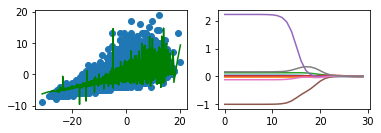

In [149]:
train_fwr()  [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]

0 [[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
1 [[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
2 [[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
3 [[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
4 [[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
5 [[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
6 [[ 0.    0.    0.01  0.06  0.    0.    0.    0.  ]]
7 [[ 0.    0.    0.01  0.06  0.    0.    0.    0.01]]
8 [[ 0.    0.    0.01  0.06  0.    0.    0.    0.02]]
9 [[ 0.    0.    0.01  0.06  0.    0.    0.    0.03]]
10 [[ 0.    0.    0.01  0.06  0.    0.    0.    0.04]]
11 [[ 0.    0.    0.01  0.06  0.    0.    0.    0.05]]
12 [[ 0.    0.    0.01  0.06  0.    0.    0.    0.06]]
13 [[ 0.    0.    0.01  0.06  0.    0.    0.    0.07]]
14 [[ 0.    0.    0.01  0.06  0.    0.    0.    0.08]]
15 [[ 0.    0.    0.01  0.05  0.    0.    0.    0.08]]
16 [[ 0.    0.    0.01  0.05  0.    0.    0.    0.09]]
17 [[ 0.    0.    0.01  0.05  0.    0.    0.    0.1 ]]
18 [[ 0.    0.    0.

156 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
157 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
158 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
159 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
160 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
161 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
162 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
163 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
164 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
165 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
166 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
167 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
168 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
169 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
170 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
171 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
172 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
173 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.   

315 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
316 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
317 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
318 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
319 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
320 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
321 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
322 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
323 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
324 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
325 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
326 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
327 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
328 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
329 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
330 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
331 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
332 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.   

468 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
469 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
470 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
471 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
472 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
473 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
474 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
475 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
476 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
477 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
478 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
479 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
480 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
481 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
482 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
483 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
484 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
485 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.   

619 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
620 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
621 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
622 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
623 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
624 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
625 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
626 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
627 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
628 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
629 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
630 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
631 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
632 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
633 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
634 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
635 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
636 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.   

769 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
770 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
771 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
772 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
773 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
774 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
775 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
776 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
777 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
778 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
779 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
780 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
781 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
782 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
783 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
784 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
785 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
786 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.   

927 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
928 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
929 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
930 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
931 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
932 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
933 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
934 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
935 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
936 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
937 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
938 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
939 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
940 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
941 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
942 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
943 [[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
944 [[ 0.04  0.    0.09  0.03  0.31 -0.64  0.   

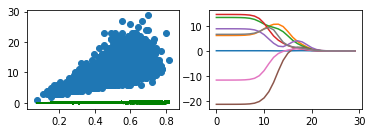

In [151]:
train_fwr()